In [10]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pickle5 as pickle
from collections import Counter

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

# Customer Segmentation

I am gonna use unsupervised learning techniques to **describe the relationship between the demographics of the company's existing customers and the general population of Germany.**

GOAL - To find parts of the general population that are more likely to be part of the customer base and so target these group in a marketing campaign.

I am gonna run a PCA on the azdias data in order to eliminate noise and capture most of the variability in the data. Then I will transform customers data as well and finally use K-means algo to cluster the data and compare clusters.

## 1. PCA

In [11]:
def load_data(file_path):
    """It loads a pickle file."""
    file = open(file_path,'rb')
    object_file = pickle.load(file)
    file.close()
    return object_file

In [12]:
# load in preprocessed CUSTOMERS data and AZDIAS data
customers_df = load_data("../data/CUSTOMERS_DF.pkl")
azdias_df = load_data("../data/AZDIAS_DF.pkl")

In [13]:
# customers_df shape
print(customers_df.shape)
print(azdias_df.shape)

(69341, 293)
(428771, 293)


In [14]:
# convert all to float
azdias_df.astype(dtype='float64')
customers_df.astype(dtype='float64')

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1.0,10.0,10.0,1.0,0.0,0.0,2.0,1.0,0.0,1.0,...,3.0,5.0,3.0,2.0,6.0,9.0,7.0,3.0,1.0,4.0
1,1.0,6.0,9.0,1.0,0.0,0.0,1.0,1.0,0.0,3.0,...,4.0,10.0,13.0,11.0,6.0,9.0,2.0,3.0,2.0,4.0
2,1.0,11.0,10.0,1.0,0.0,0.0,2.0,1.0,0.0,3.0,...,4.0,1.0,2.0,1.0,6.0,9.0,1.0,2.0,1.0,3.0
3,1.0,10.0,10.0,1.0,0.0,0.0,2.0,1.0,0.0,2.0,...,4.0,3.0,4.0,2.0,6.0,9.0,7.0,1.0,1.0,4.0
4,1.0,10.0,9.0,1.0,0.0,0.0,2.0,1.0,0.0,3.0,...,3.0,1.0,2.0,1.0,6.0,9.0,3.0,3.0,1.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69336,3.0,15.0,15.0,2.0,0.0,0.0,1.0,2.0,0.0,4.0,...,2.0,4.0,5.0,3.0,3.0,7.0,5.0,1.0,1.0,3.0
69337,1.0,9.0,9.0,1.0,0.0,0.0,1.0,1.0,0.0,2.0,...,2.0,4.0,6.0,3.0,6.0,9.0,7.0,1.0,1.0,4.0
69338,2.0,13.0,13.0,7.0,0.0,0.0,1.0,5.0,0.0,3.0,...,4.0,3.0,3.0,2.0,4.0,9.0,3.0,3.0,2.0,4.0
69339,1.0,13.0,13.0,5.0,0.0,0.0,1.0,3.0,0.0,3.0,...,4.0,1.0,2.0,1.0,6.0,9.0,4.0,3.0,2.0,2.0


### 1.1. PCA Fit_tranform AZDIAS

I will use the function below to run PCA on AZDIAS and plot a scree plot showing the cumulative explained variability.
The explained variability threshold will be 80%.

In [15]:
def pca_function(df, threshold, show_scree_plot=True, scaled=False):
    '''
    It takes a pandas dataframe and a desired threshold, scales the numeric features 
    and performs principal component analysis dimension reduction, and returns
    a pandas dataframe of lower dimensionality and variance explained to the given
    threshold.

    Parameters
    ----------
    df: pandas dataframe. The dataframe containing data to perform PCA on
    threshold: int. The desired % of variance explained to be included in the return; must be an number between 0 and 100
    show_scree_plot: boolean. Bool indicating whether or not to display scree plot showing the % variance explained by each principal component; 
    default set to True
    scaled : boolean. Bool indicating whether the numeric data has been scaled; default set to False

    Returns
    -------
    dataframe: a pandas dataframe where the numeric columns have been scaled and dimensions reduced to the number
    of principal components which explain the variance at a given threshold.
    '''
  
    #confirm proper threshold input:
    assert threshold >= 0, ValueError("Threshold must be a number between 0 and 100")
    assert threshold <= 100, ValueError("Threshold must be a number between 0 and 100")

    X = df.copy()

    if scaled == False:
        #scale the data:
        scaler = StandardScaler()
        scaled_X = scaler.fit_transform(X)
    else:
        scaled_X = X

    #calc the principal component variance
    n = len(list(X.columns))
    covar_matrix = PCA(n_components = n)
    covar_matrix.fit(scaled_X)

    ##calculate variance ratios
    variance = covar_matrix.explained_variance_ratio_
    cumulative_var = np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3)*100)

    #function for calculating number of principal components to use:
    def calc_num_components(cum_var, threshold):
        for i in range(n):
            if cum_var[i] >= threshold:
                return i+1

    #call the function to calulate num_components:
    n_components = calc_num_components(cumulative_var, threshold)

    # create the PCA instance
    pca = PCA(n_components = n_components, random_state=42)
    principal_components = pca.fit_transform(scaled_X)

    #scree plot function
    '''
    colors = ['red' if x == n_components else 'grey' for x in X_vals]
    sb.barplot(x=idx, y=values, palette=colors)'''

    def make_scree(cumulative_variance, threshold):

        n = len(cumulative_variance)
        y_vals = [num for num in cumulative_variance]
        x_vals = [num for num in range(1,n+1)]

        colors = ['red' if x == n_components else '#769ddb' for x in x_vals]
        width = min(n/3, 20)
        height = min(n/4, 16)
        fig, ax = plt.subplots(figsize=(width,height))
        ax.grid(True)
        ax.set_title('Principal Components Cumulative Variance')
        ax.set_ylabel('Cumulative Variance % Explained')
        ax.set_xlabel('Principal Components')

        # threshold var
        ax.axhline(threshold, color='black', linewidth=1);
        sns.barplot(x=x_vals, y=y_vals, ax=ax, palette=colors)
        plt.show()

    if show_scree_plot:
    #plot it:
        make_scree(cumulative_var, threshold)

    #convert to pandas df:
    pc_df = pd.DataFrame(data = principal_components, 
                       columns = ['component_' + str(i) for i in range(1, n_components+1)])

    #return df which is original df w/ the numeric cols dropped and replaced w/
    #principal components df

    df = pd.concat([df, pc_df], axis=1).drop(columns = list(X.columns))
    return pca, principal_components, df

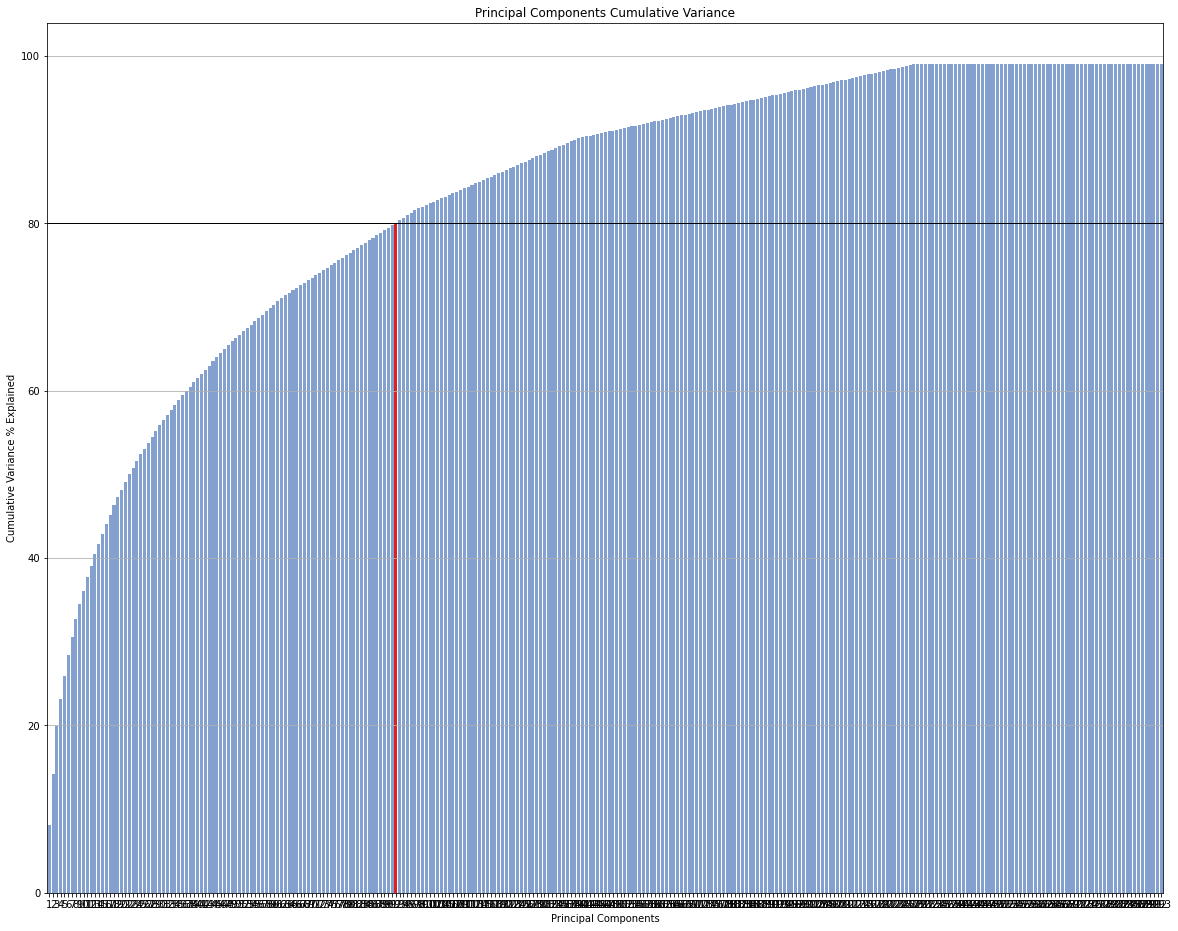

In [16]:
# run pca and plot scree plot
azdias_pca, azdias_pca_X, azdias_pca_df = pca_function(df=azdias_df, threshold=80, show_scree_plot=True, scaled=False)

In [59]:
azdias_pca_df

,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10,...,component_83,component_84,component_85,component_86,component_87,component_88,component_89,component_90,component_91,component_92
0,-2.343792,1.616278,-1.114046,-2.205389,1.813397,-0.038278,0.386745,-2.854154,-0.616526,-2.639842,...,0.608882,-0.863811,0.651282,-0.257084,-0.427003,0.024610,-0.206984,-0.835272,0.022330,0.588677
1,2.960860,-1.471133,4.932451,-2.663934,-0.771410,-2.812859,-5.325411,2.296560,0.153865,-0.644918,...,-0.084850,0.114894,0.857073,0.804241,1.741622,0.038668,0.792615,-0.109850,-0.186585,0.258138
2,-0.631211,3.247127,0.286628,-2.632967,2.720067,3.789809,-5.112486,0.076590,3.544996,-1.634553,...,0.682049,-0.508351,0.909544,-1.274089,0.936288,0.070280,0.797610,0.562820,0.674100,-1.045215
3,-2.254604,7.976185,-0.962559,-2.348200,2.245736,1.117261,-1.058277,1.717833,-0.387802,2.462920,...,0.122754,0.356489,-0.666838,1.079456,-1.586754,-1.057598,-0.057067,-1.122829,-0.057387,-1.286752
4,-1.492205,11.913649,-0.443667,3.490989,3.528208,-4.027021,-1.773856,-1.013801,-3.550264,4.571069,...,-0.973255,-1.025557,-0.384681,0.598083,-0.263157,0.138342,0.301122,-0.462064,-0.069760,-0.524379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428766,9.746136,2.192973,2.198439,0.731858,-1.196727,-2.115884,-3.839046,-2.958140,-3.718570,1.077233,...,-1.572994,0.198285,-1.266280,0.647157,-0.567767,0.867322,0.204398,-1.994022,1.823114,1.003847
428767,7.268184,-4.928230,-1.880334,-2.719366,-1.850505,0.621508,-0.453140,0.281351,2.783665,-1.778020,...,-0.124246,1.105271,1.041009,2.484181,-1.724475,-0.833834,-0.030332,0.224530,-1.058505,1.354293
428768,9.008376,2.852887,2.013786,-1.109194,-0.108447,-1.022838,5.756674,3.373617,-2.619572,2.263055,...,-1.244115,1.057978,-1.038260,-0.001500,0.073975,-0.259856,-0.388851,-1.367735,-0.835664,-0.656815
428769,6.932333,2.655428,4.304176,-3.497544,-0.655047,-3.001856,-0.468717,-1.752150,2.852632,-0.586457,...,-0.233135,0.131004,-1.939150,0.810153,-0.432183,0.325497,-2.781241,0.032963,-1.635247,-0.255497


In [17]:
print("80% percent of the variability in the data is explained by {} principal components.".format(azdias_pca_X.shape[1]))

80% percent of the variability in the data is explained by 92 principal components.


In [18]:
azdias_df.shape

(428771, 293)

I have reduced the noise in the data and reduce the dimensionality from 293 columns to 92.

### 1.2. Investigate relationship between AZDIAS feature and Principal Components

A **principal component (PC)** is a unit vector that points in the direction of highest variance of the data points projected in a new subspace, after accounting for the variance captured by the earlier PC.

I am gonna map each feature weight to its corresponding feature and sort the by weight in order to find out which features are more important for each PC. The most interesting features will be those at the beginning and end of the sorted weights. This is due to the following:

- The larger the feature weight (in absoulte values), the more the PC is in the direction of the feature.

- If two features have large weights of the same sign (both positive or both negative), then an increase in one feature will yield an increase in the other. They show a positive correlation.

- Similarly, two features with weights of different signs will be expected to show a negative correlation.

In [19]:
azdias_pca.components_.shape

(92, 293)

In [20]:
azdias_pca_df.head()

,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10,...,component_83,component_84,component_85,component_86,component_87,component_88,component_89,component_90,component_91,component_92
0,-2.343792,1.616278,-1.114046,-2.205389,1.813397,-0.038278,0.386745,-2.854154,-0.616526,-2.639842,...,0.608882,-0.863811,0.651282,-0.257084,-0.427003,0.024610,-0.206984,-0.835272,0.022330,0.588677
1,2.960860,-1.471133,4.932451,-2.663934,-0.771410,-2.812859,-5.325411,2.296560,0.153865,-0.644918,...,-0.084850,0.114894,0.857073,0.804241,1.741622,0.038668,0.792615,-0.109850,-0.186585,0.258138
2,-0.631211,3.247127,0.286628,-2.632967,2.720067,3.789809,-5.112486,0.076590,3.544996,-1.634553,...,0.682049,-0.508351,0.909544,-1.274089,0.936288,0.070280,0.797610,0.562820,0.674100,-1.045215
3,-2.254604,7.976185,-0.962559,-2.348200,2.245736,1.117261,-1.058277,1.717833,-0.387802,2.462920,...,0.122754,0.356489,-0.666838,1.079456,-1.586754,-1.057598,-0.057067,-1.122829,-0.057387,-1.286752
4,-1.492205,11.913649,-0.443667,3.490989,3.528208,-4.027021,-1.773856,-1.013801,-3.550264,4.571069,...,-0.973255,-1.025557,-0.384681,0.598083,-0.263157,0.138342,0.301122,-0.462064,-0.069760,-0.524379


In [21]:
azdias_pca_df.shape

(428771, 92)

In [22]:
def get_pc_weights(pca, pc_num, data):
    """It gets the weights assigned to each feature for a given PC.
    Parameters
    ----------
    pca: Sklearn PCA fitted on training data
    pc_num: int. PC number
    data: Original Pandas DataFrame
    Returns
    ----------
    weights: 
    """
    df = pd.DataFrame(pca.components_, columns = list(data.columns)).transpose()
    weights = df.loc[:, pc_num - 1].sort_values(ascending=False)
        
    return weights

In [23]:
def plot_feature_weights_by_pc(weights, pc_num):
    """It plots a bar chart showing the weights by feature in a given Principal Component(PC).
    
    Parameters
    ----------
    weights: Series. Weights by feature by component
    pc_num: int. Principal components for which weights by feature are displayed
    
    Returns
    ----------
    None
    """
    
    # plot bar chart with all weights by feature
    plt.figure(figsize=(15,7))
    plt.bar([i for i in range(1, len(weights.index.tolist())+1)], weights.values.tolist())
    plt.title("Weight by feature by PC{}".format(pc_num))
    plt.xlabel("Feature #")
    plt.ylabel("Feature Weight")
    plt.show();
    
    # plot bar chart with only the first 3 weights and the last 3 weights
    plt.figure(figsize=(15,7))
    plt.bar(weights.iloc[[0, 1, 2, -3, -2, -1]].index.tolist(), 
            weights.iloc[[0, 1, 2, -3, -2, -1]].values.tolist())
    plt.title("Weight by feature by PC{}".format(pc_num))
    plt.xlabel("Feature name")
    plt.ylabel("Feature Weight")
    plt.show();
    
    # print weight by feature sorted by weight
    print("List of weights by feature by PC{}".format(pc_num))
    pd.set_option('display.max_rows', weights.shape[0])
    print(weights)

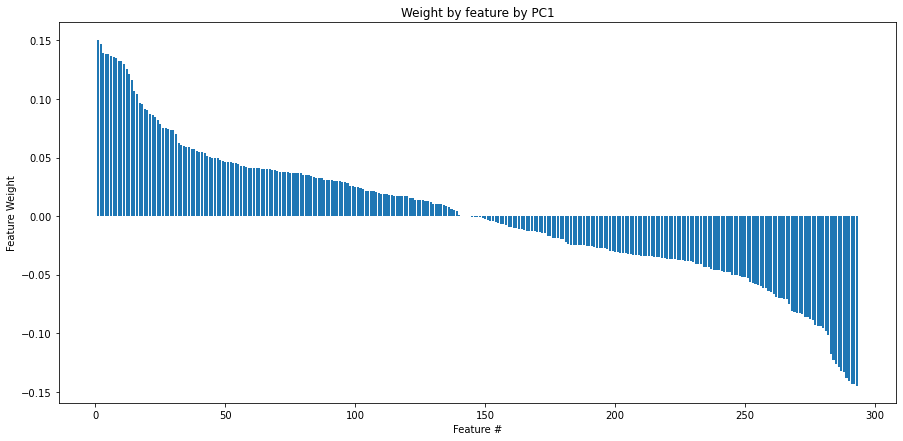

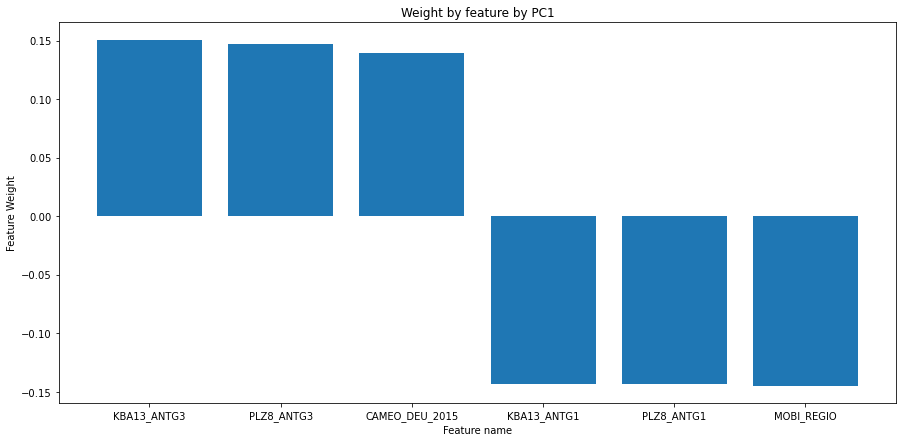

List of weights by feature by PC1
KBA13_ANTG3                    0.150774
PLZ8_ANTG3                     0.147341
CAMEO_DEU_2015                 0.139655
ANZ_HAUSHALTE_AKTIV            0.138352
CAMEO_DEUG_2015                0.138115
HH_EINKOMMEN_SCORE             0.136771
CAMEO_INTL_2015                0.135752
KBA13_BAUMAX                   0.134755
ANZ_STATISTISCHE_HAUSHALTE     0.132827
PLZ8_BAUMAX                    0.132364
PLZ8_ANTG2                     0.129483
PLZ8_ANTG4                     0.125344
KBA13_ANTG2                    0.121709
KBA05_ANTG3                    0.116158
EWDICHTE                       0.107205
ORTSGR_KLS9                    0.104513
ARBEIT                         0.096508
FINANZ_HAUSBAUER               0.095361
CJT_TYP_2                      0.091158
KBA13_HALTER_30                0.090186
KBA05_BAUMAX                   0.086783
RELAT_AB                       0.086554
FINANZ_SPARER                  0.084788
ZABEOTYP                       0.081670
KBA13_

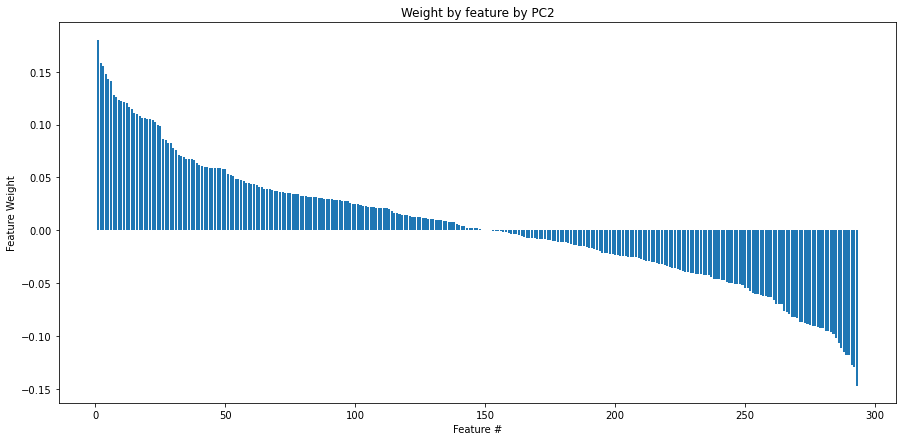

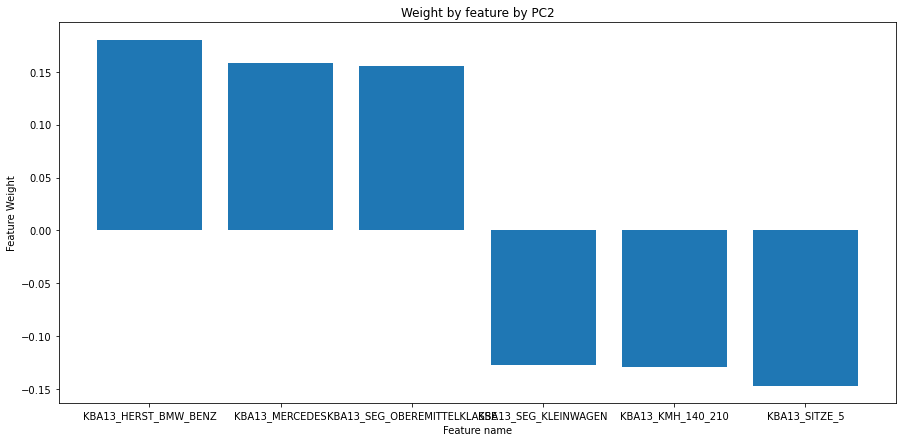

List of weights by feature by PC2
KBA13_HERST_BMW_BENZ           0.180332
KBA13_MERCEDES                 0.157908
KBA13_SEG_OBEREMITTELKLASSE    0.155581
KBA13_BMW                      0.147753
KBA13_SITZE_4                  0.143478
KBA13_SEG_SPORTWAGEN           0.140803
KBA05_HERST1                   0.127700
KBA13_KMH_211                  0.125761
KBA13_KMH_250                  0.123507
KBA13_KW_121                   0.121935
KBA13_SEG_OBERKLASSE           0.121754
KBA05_KW3                      0.120091
KBA13_CCM_2501                 0.116934
EWDICHTE                       0.114586
KBA13_HALTER_65                0.110914
KBA13_CCM_3000                 0.109929
KBA05_MOTOR                    0.108302
KBA13_KRSHERST_BMW_BENZ        0.106509
KBA05_MOD1                     0.106140
STRUKTURTYP                    0.105469
KBA05_CCM4                     0.105167
KBA13_CCM_3001                 0.104311
ORTSGR_KLS9                    0.102089
KBA13_ALTERHALTER_61           0.099149
KBA05_

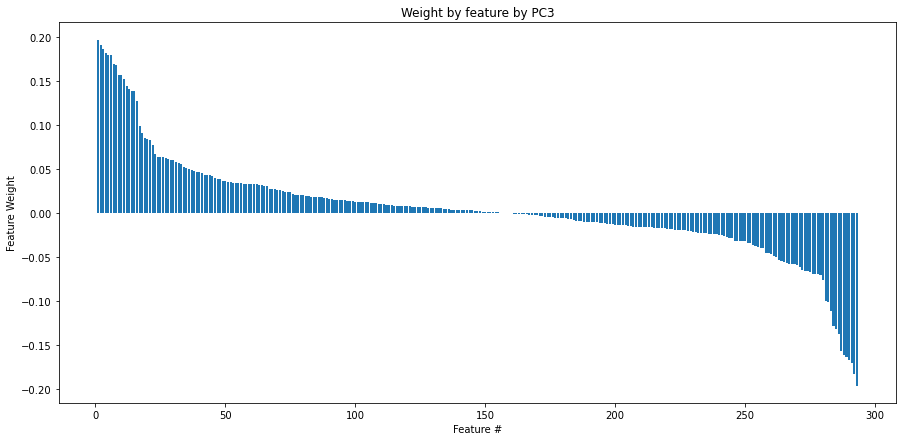

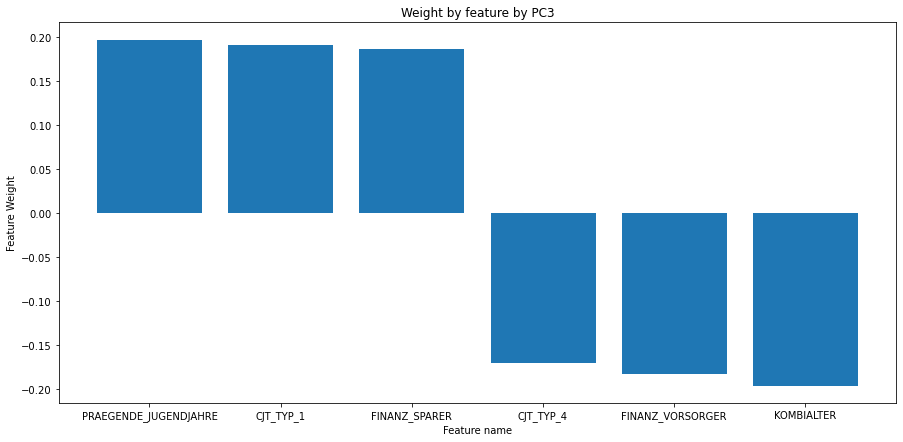

List of weights by feature by PC3
PRAEGENDE_JUGENDJAHRE          0.197456
CJT_TYP_1                      0.191112
FINANZ_SPARER                  0.187202
CJT_TYP_2                      0.181779
ALTERSKATEGORIE_FEIN           0.180119
FINANZ_ANLEGER                 0.180060
ALTER_HH                       0.169898
FINANZ_UNAUFFAELLIGER          0.169071
GEBURTSJAHR                    0.157618
SEMIO_PFLICHT                  0.157354
SEMIO_TRADV                    0.153135
SEMIO_RAT                      0.144901
RT_UEBERGROESSE                0.141655
SEMIO_REL                      0.139347
RT_KEIN_ANREIZ                 0.138829
ONLINE_AFFINITAET              0.127433
CJT_GESAMTTYP                  0.098806
EINGEZOGENAM_HH_JAHR           0.091363
SEMIO_KULT                     0.085501
SEMIO_MAT                      0.084876
UMFELD_ALT                     0.083492
ANZ_KINDER                     0.076981
KBA13_AUTOQUOTE                0.067149
D19_GESAMT_ANZ_24              0.064346
GEMEIN

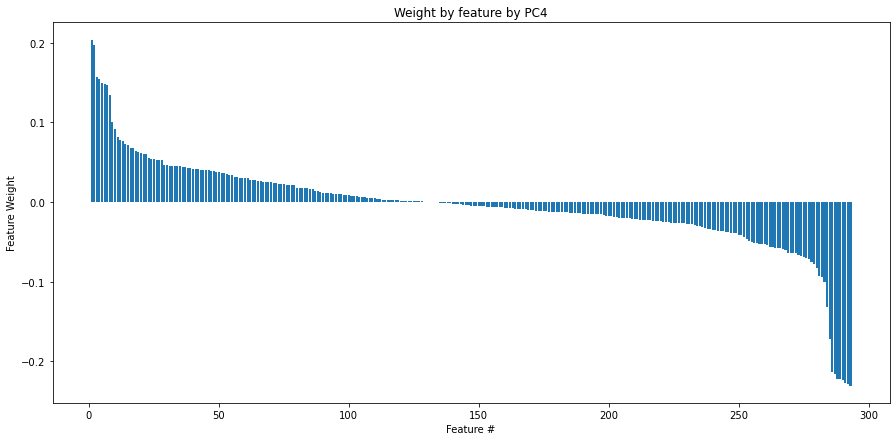

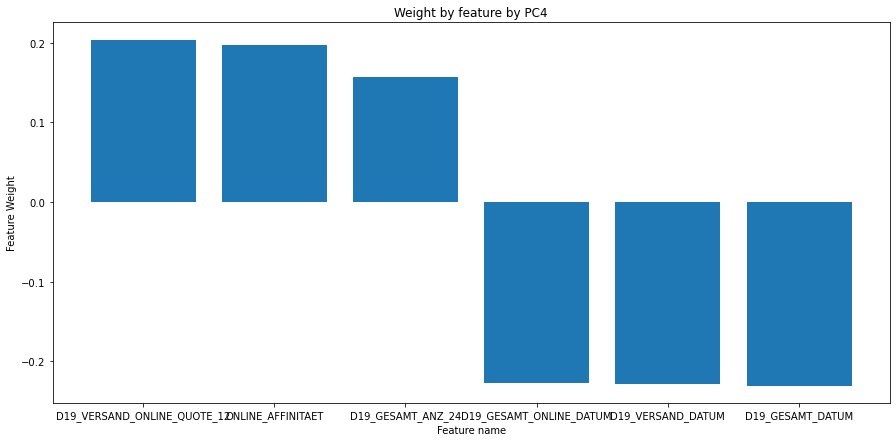

List of weights by feature by PC4
D19_VERSAND_ONLINE_QUOTE_12    0.203905
ONLINE_AFFINITAET              0.197184
D19_GESAMT_ANZ_24              0.157379
LP_LEBENSPHASE_FEIN            0.154143
LP_FAMILIE_GROB                0.149466
LP_LEBENSPHASE_GROB            0.147954
ANZ_PERSONEN                   0.146707
LP_FAMILIE_FEIN                0.134196
ANZ_KINDER                     0.101044
ARBEIT                         0.091232
ORTSGR_KLS9                    0.081327
EWDICHTE                       0.078363
GREEN_AVANTGARDE               0.076685
KBA05_VORB0                    0.072389
KBA13_ANTG3                    0.071458
KBA13_FAB_SONSTIGE             0.068051
KBA13_HERST_SONST              0.068051
PLZ8_ANTG3                     0.064532
KBA13_HERST_ASIEN              0.062933
STRUKTURTYP                    0.061919
RELAT_AB                       0.060397
KBA13_HALTER_30                0.059868
PLZ8_ANTG4                     0.055029
KBA13_ALTERHALTER_30           0.053956
KBA13_

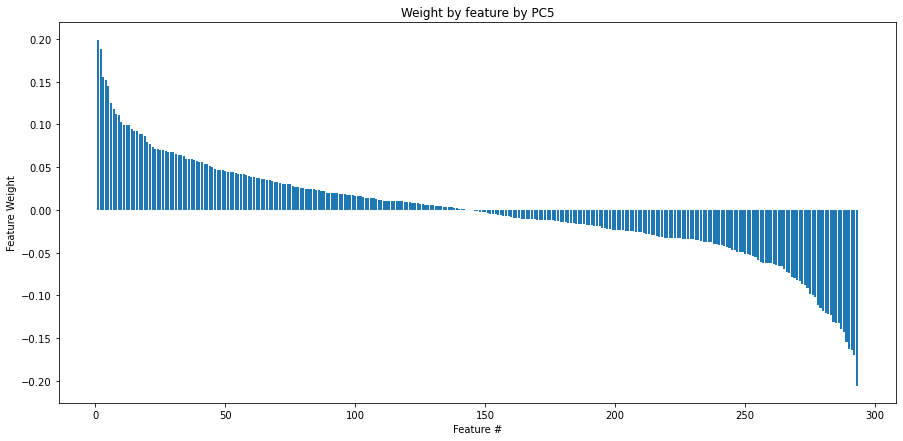

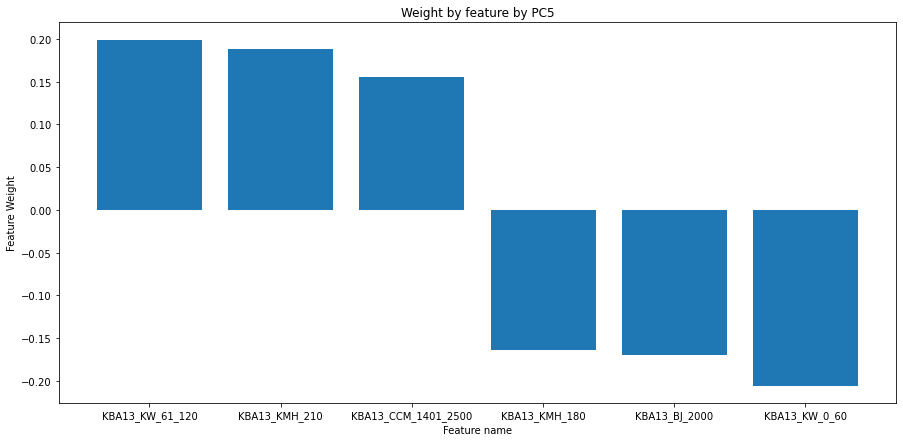

List of weights by feature by PC5
KBA13_KW_61_120                0.199199
KBA13_KMH_210                  0.188437
KBA13_CCM_1401_2500            0.155290
KBA13_SITZE_5                  0.151806
KBA13_VORB_0                   0.145292
KBA13_HALTER_25                0.125372
KBA13_ALTERHALTER_30           0.118558
KBA13_CCM_2000                 0.112598
KBA13_KRSZUL_NEU               0.111341
KBA13_KW_110                   0.102738
KBA13_SEG_MITTELKLASSE         0.099649
KBA13_BJ_2006                  0.098826
KBA13_KRSHERST_BMW_BENZ        0.098805
KBA13_HALTER_30                0.094431
KBA13_BJ_2008                  0.092284
KBA13_BJ_2009                  0.091947
KBA13_FAB_SONSTIGE             0.089171
KBA13_HERST_SONST              0.089171
KBA13_HERST_ASIEN              0.086697
KBA13_KW_90                    0.079191
ARBEIT                         0.077312
D19_GESAMT_DATUM               0.073748
KBA13_SEG_KOMPAKTKLASSE        0.071660
D19_GESAMT_ONLINE_DATUM        0.071336
D19_KO

In [24]:
# investigate first 5 principal components
for i in range(1, 6):
    plot_feature_weights_by_pc(weights=get_pc_weights(pca=azdias_pca, pc_num=i, data=azdias_df), pc_num=i)

I can investigate which features have more importance in each PC by looking at the weight by feature plots. This will come handy to get insights from the underepresented groups of the general population in our customers base.

### 1.3. PCA tranform Customers

In [25]:
# scale the data

# initialize scaler
scaler = StandardScaler()

# sacale data
scaled_customers_df = scaler.fit_transform(customers_df)

# transform data with pca fitted on AZDIAS data
customers_pca_X = azdias_pca.transform(scaled_customers_df)

## 2. K-means Clustering

I am going to use K-means to obtaing the clusters in the new subspace that contains the principal components (PC).

K-Means algorithm requires a predefined number of clusters. In order to find an optimal number of cluster, I am gonna use the Elbolw method.

### 2.1. Elbow graph

In [26]:
def elbow_plot(data, start_K, end_K, step):
    '''It generates an elbow plot to help find an optimal n_clusters for K-Means.
    Parameters
    ----------
    data: array with PCA data
    start_K: int. Smaller number of clusters
    end_K: int. Larger number of clusters
    step: int. Step
    '''
    
    scores = []
    for i in range(start_K, end_K, step):
        kmeans = KMeans(n_clusters=i)
        model = kmeans.fit(data)
        score = model.score(data)
        scores.append(abs(score))

    plt.figure(figsize=(14, 7))
    plt.plot(range(start_K, end_K, step), scores, linestyle='--', marker='h', color='b');
    plt.xlabel('# of clusters K');
    plt.ylabel('Sum of squared errors');
    plt.title('SSE vs. K');
    plt.savefig('elbow_plot.png')

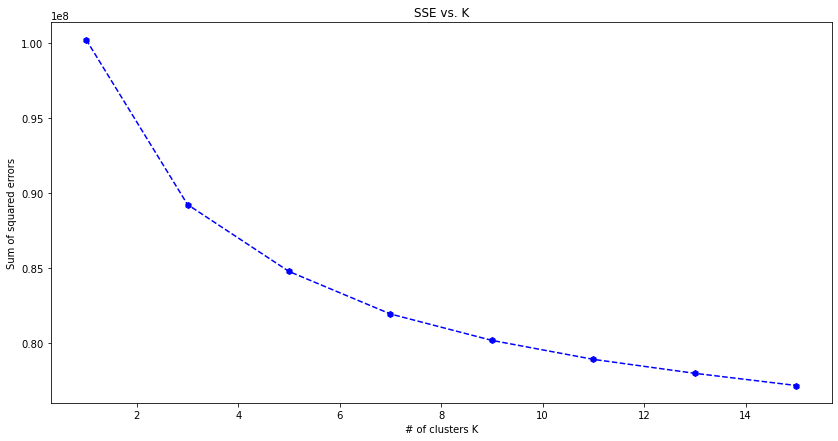

In [27]:
# Elbow plot for AZDIAS
elbow_plot(azdias_pca_X, 1, 16, 2)

By looking at the elbow plot, it seems like the optimal number of clusters is 9.

### 2.2. Clustering using KMeans

In [28]:
# fit KMeans on azdias to obtain clusters for the general population of Germany

# instantiate model
kmeans = KMeans(n_clusters=9)

# fit model on training data and obtain clusters
azdias_labels = kmeans.fit_predict(azdias_pca_X)
azdias_labels

array([8, 3, 3, ..., 4, 4, 4], dtype=int32)

In [29]:
# predict customer clusters using KMeans fitted on azdias data
customers_labels = kmeans.predict(customers_pca_X)
customers_labels

array([6, 1, 5, ..., 4, 5, 5], dtype=int32)

In [30]:
customers_labels.shape

(69341,)

In [31]:
azdias_labels.shape

(428771,)

### 2.3. Comparison of proportion of individuals in each cluster

In [32]:
def get_prop_by_cluster(labels, population):
    """It calculates de proportion of individuals in each cluster.
    Parameters
    ----------
    labels: array. Assigned cluster to each individual by KMeans clustering
    population: int. Number of individuals in the original preprocessed dataset
    
    Returns
    ----------
    proportions: dict. Dictionary with proportions in each cluster.
    """
    counts = Counter(labels)
    proportions = {i+1: ((counts[i] / population) * 100) for i in sorted(counts)}
    
    return proportions

In [33]:
# calculate proportions
azdias_proportions = get_prop_by_cluster(azdias_labels, azdias_df.shape[0])
customers_proportions = get_prop_by_cluster(customers_labels, customers_df.shape[0])

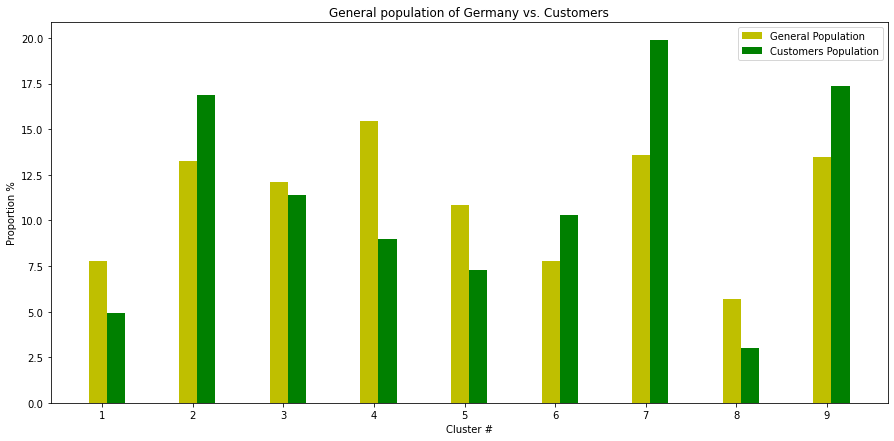

In [34]:
# plot bar chart with proportions
plt.figure(figsize=(15,7))
plt.bar([i-0.05 for i in azdias_proportions.keys()], azdias_proportions.values(),
        width=0.2, align='center', color='y', label='General Population')
plt.bar([i+0.05 for i in customers_proportions.keys()], customers_proportions.values(),
        width=.2, align='edge',color='g', label='Customers Population')
plt.title("General population of Germany vs. Customers")
plt.xlabel("Cluster #")
plt.ylabel("Proportion %")
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9])
plt.legend()
plt.show();

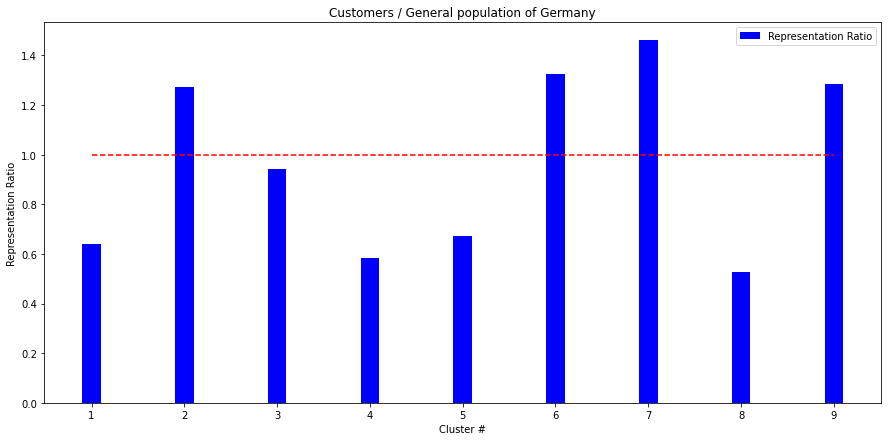

In [94]:
cust_by_population = [
    cust / population
    for cust, population in zip(customers_proportions.values(), azdias_proportions.values())
]

# plot bar chart with proportions
plt.figure(figsize=(15,7))
plt.bar(azdias_proportions.keys(), cust_by_population,
        width=0.2, align='center', color='b', label='Representation Ratio')
plt.title("Customers / General population of Germany")
plt.xlabel("Cluster #")
plt.ylabel("Representation Ratio")
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9])
plt.hlines(y=1, xmin=1, xmax=9, colors='r', linestyles='dashed')
plt.legend()
plt.show();

**Over-represented groups**

Clusters 2, 6, 7 and 9.

**Under-represented groups**

Clusters 1, 4, 5 and 8.

I can see in the graph above that clusters 2, 6, 7 and 9 are over-represented in our customers base. However, clusters 1, 4, 5 and 8 are under-represented.

In order to understand who are the people in these groups, I am going to inverse tranform the cluster centers using the PCA model previously trained and this will give me the feature weights.

In [74]:
def get_feature_weights_cluster(pca_model, clustering_model, cluster):
    """It inversely transforms the cluster centers using a PCA model to find feature weights.
    Parameters
    ----------
    pca_model: PCA model trained on general population data
    clustering_model: KMeans model trained on PCA transformed general population
    cluster: int. Cluster number
    
    Returns
    ----------
    weights_by_feature: Series. Sorted weights by feature
    """
    feature_weigths = pca_model.inverse_transform(clustering_model.cluster_centers_[cluster - 1])
    # convert to series
    weigths_by_feature = pd.Series(feature_weigths, index=azdias_df.columns).sort_values()
    
    return weigths_by_feature

In [103]:
def plot_feature_weights(weights):
    """It plots a bar chart showing the weights by feature.
    
    Parameters
    ----------
    weights: Series. Weights by feature.
    
    Returns
    ----------
    None
    """
    
    # plot bar chart with all weights by feature
    plt.figure(figsize=(15,7))
    plt.bar([i for i in range(1, len(weights.index.tolist())+1)], weights.values.tolist(), color='lightcoral')
    plt.title("Weight by feature")
    plt.xlabel("Feature #")
    plt.ylabel("Feature Weight")
    plt.show();
    
    # plot bar chart with only the first 3 weights and the last 3 weights
    plt.figure(figsize=(15,7))
    plt.bar(weights.iloc[[0, 1, 2, -3, -2, -1]].index.tolist(), 
            weights.iloc[[0, 1, 2, -3, -2, -1]].values.tolist(), color='lightcoral')
    plt.title("Weight by feature")
    plt.xlabel("Feature name")
    plt.ylabel("Feature Weight")
    plt.show();

### 2.4. Under-represented Clusters

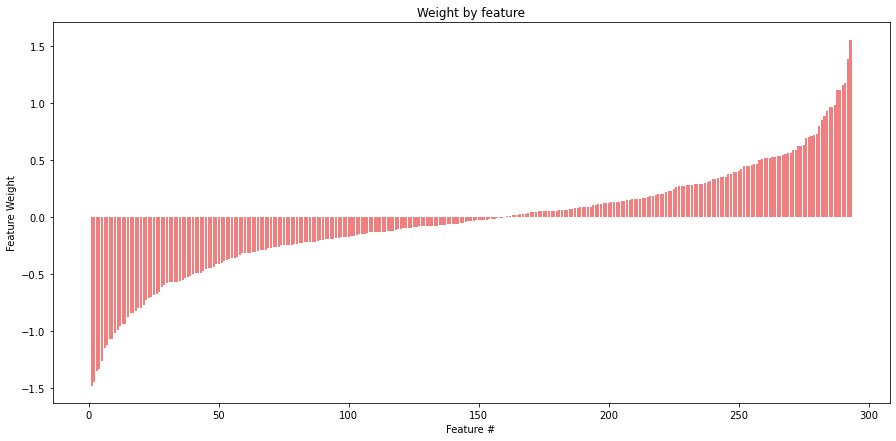

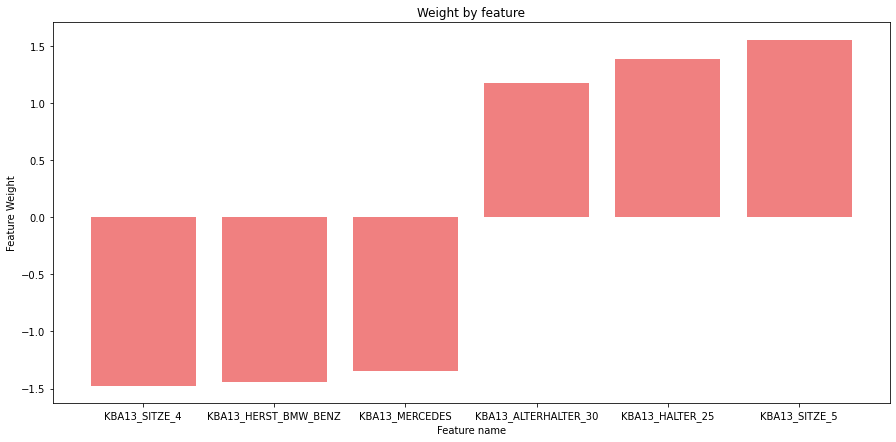

In [88]:
# get under-represented cluster 1 weights by feature
under_cluster_1 = get_feature_weights_cluster(azdias_pca, kmeans, cluster=1)

# plot weights by feature for under-represented cluster 1 
plot_feature_weights(under_cluster_1)

**Under-represented Cluster 1**

Features `KBA13_SITZE_5`, `KBA13_HALTER_25` and `KBA13_ALTERHALTER_30` show positive correlation whereas `KBA13_SITZE_4`, `KBA13_HERST_BMW_BENZ`and `KBA13_MERCEDES` show negative correlation.

By looking at the attributes meaning, `KBA13_SITZE_5` represents people with 5 seater cars and `KBA13_HALTER_25` and `KBA13_ALTERHALTER_30` represent groups of people with cars between 21 and 30 years old.

In contrast, `KBA13_SITZE_4` represents people who owns cars with less than 5 seats and `KBA13_HERST_BMW_BENZ` and `KBA13_MERCEDES` represent owners of luxurious cars.

This cluster is likely to represent **young people with average cars and income**.


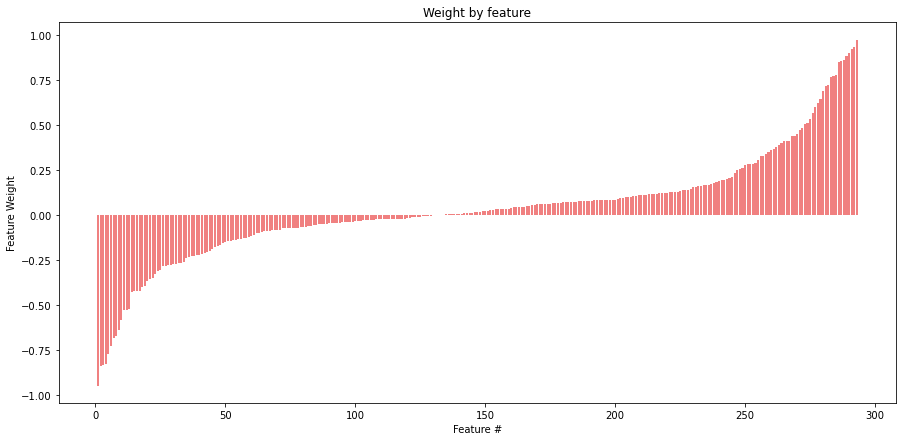

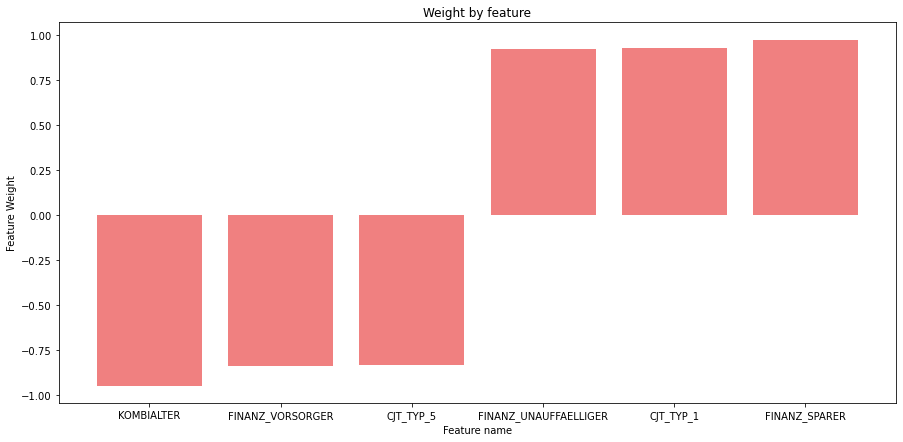

In [95]:
# get under-represented cluster 4 weights by feature
under_cluster_4 = get_feature_weights_cluster(azdias_pca, kmeans, cluster=4)

# plot weights by feature for under-represented cluster 4 
plot_feature_weights(under_cluster_4)

**Under-represented Cluster 4**

Features `FINANZ_SPARER`, `CJT_TYP_1` and `FINANZ_UNAUFFAELLIGER` show positive correlation whereas `KOMBIALTER`, `FINANZ_VORSORGER`and `CJT_TYP_5` show negative correlation.

By looking at the attributes meaning, `FINANZ_SPARER` represents money savers. The given attributes descriptions do not provide a meaning or clear understading of the rest of the variables.

This cluster is likely to represent **people that do tend to save a lot of money and are not very interested in arranging finance.**

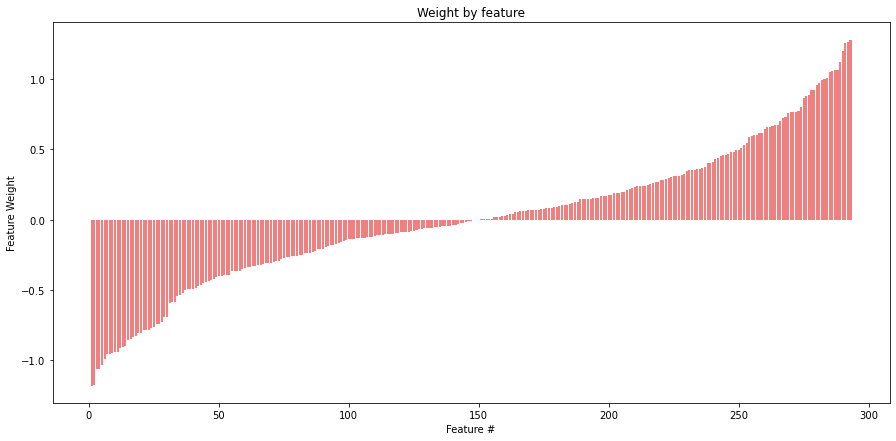

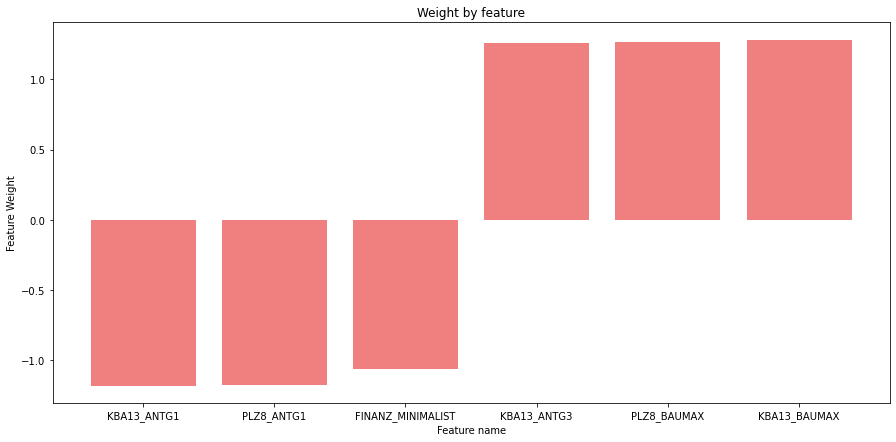

In [114]:
# get under-represented cluster 5 weights by feature
under_cluster_5 = get_feature_weights_cluster(azdias_pca, kmeans, cluster=5)

# plot weights by feature for under-represented cluster 5 
plot_feature_weights(under_cluster_5)

**Under-represented Cluster 5**

Features `KBA13_BAUMAX`, `PLZ8_BAUMAX` and `KBA13_ANTG3` show positive correlation whereas `KBA13_ANTG1`, `PLZ8_ANTG1`and `FINANZ_MINIMALIST` show negative correlation.

By looking at the attributes meaning, it is hard to tell exactly the group of people this cluster represents. The negative correlation showed by `KBA13_ANTG1`, `PLZ8_ANTG1`and `FINANZ_MINIMALIST` tells me that **people with 1-2 family homes and who looks for low financial interests are definitely not represented by this cluster.**

Note the limited understanding of the attributes meaning only allowed me to make an assumption about this cluster.

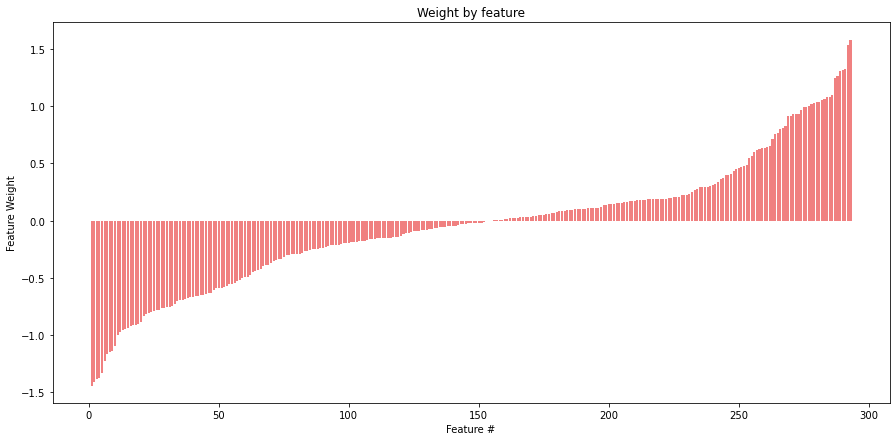

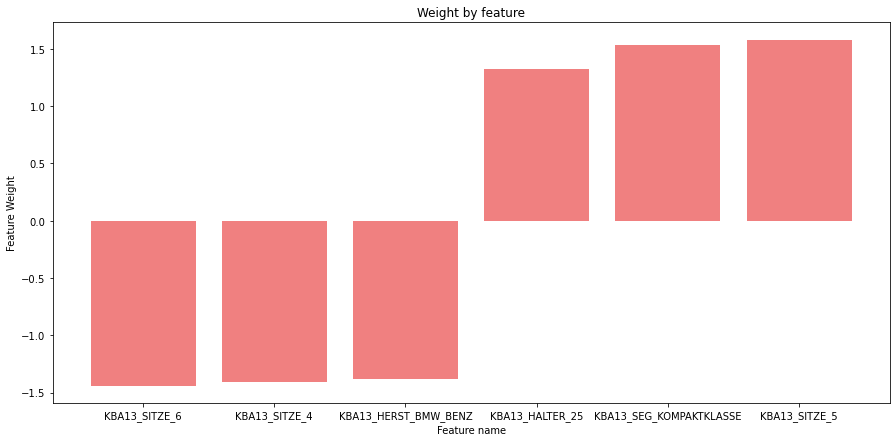

In [98]:
# get under-represented cluster 8 weights by feature
under_cluster_8 = get_feature_weights_cluster(azdias_pca, kmeans, cluster=8)

# plot weights by feature for under-represented cluster 8 
plot_feature_weights(under_cluster_8)

**Under-represented Cluster 8**

Features `KBA13_SITZE_5`, `KBA13_SEG_KOMPAKTKLASSE` and `KBA13_HALTER_25` show positive correlation whereas `KBA13_SITZE_6`, `KBA13_SITZE_4`and `KBA13_HERST_BMW_BENZ` show negative correlation.

By looking at the attributes meaning, `KBA13_SITZE_5` represents people with 5 seater cars and `KBA13_SEG_KOMPAKTKLASSE` represents owners of low/midclass cars and `KBA13_HALTER_25` represent groups of people with cars between 21 and 26 years old.

In contrast, `KBA13_SITZE_5` represents people who owns cars with more than 5 seats, `KBA13_SITZE_4` represents people who owns cars with less than 5 seats and `KBA13_HERST_BMW_BENZ` represents owners of luxurious cars.

This cluster crearly represents **young people with low midclass cars and probably low income**. We could say this cluster is quite similar to cluster number 1.

### 2.5. Over-represented Clusters

In [109]:
def plot_feature_weights_2(weights):
    """It plots a bar chart showing the weights by feature.
    
    Parameters
    ----------
    weights: Series. Weights by feature.
    
    Returns
    ----------
    None
    """
    
    # plot bar chart with all weights by feature
    plt.figure(figsize=(15,7))
    plt.bar([i for i in range(1, len(weights.index.tolist())+1)], weights.values.tolist(), color='steelblue')
    plt.title("Weight by feature")
    plt.xlabel("Feature #")
    plt.ylabel("Feature Weight")
    plt.show();
    
    # plot bar chart with only the first 3 weights and the last 3 weights
    plt.figure(figsize=(15,7))
    plt.bar(weights.iloc[[0, 1, 2, -3, -2, -1]].index.tolist(), 
            weights.iloc[[0, 1, 2, -3, -2, -1]].values.tolist(), color='steelblue')
    plt.title("Weight by feature")
    plt.xlabel("Feature name")
    plt.ylabel("Feature Weight")
    plt.show();

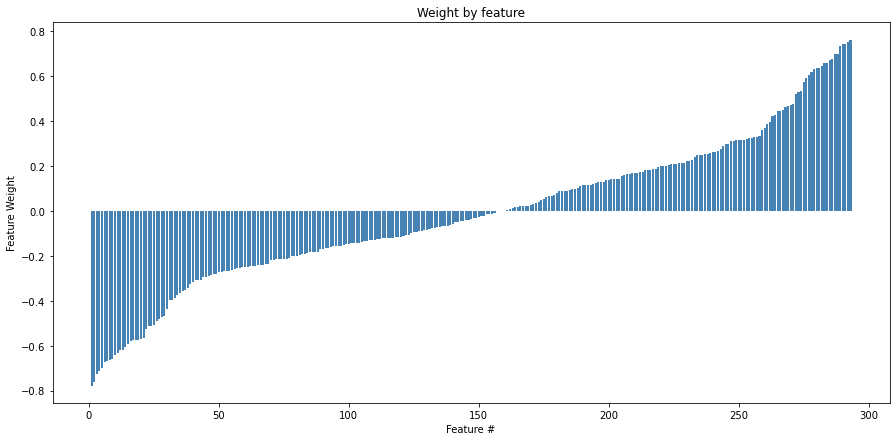

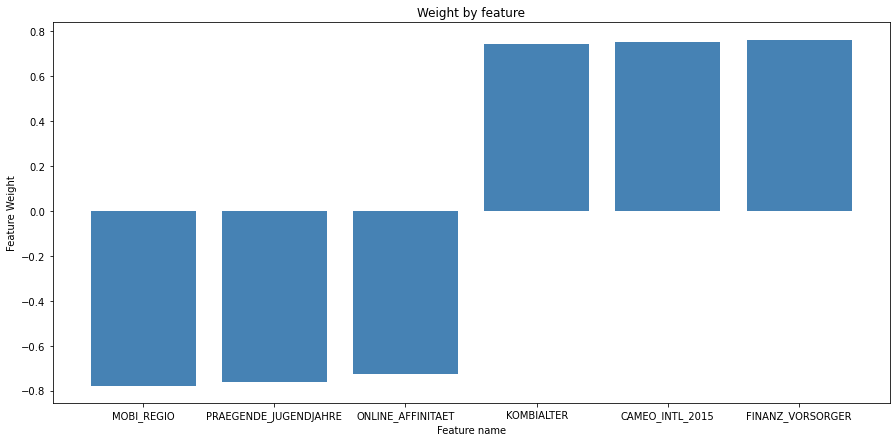

In [110]:
# get over-represented cluster 2 weights by feature
under_cluster_2 = get_feature_weights_cluster(azdias_pca, kmeans, cluster=2)

# plot weights by feature for over-represented cluster 2 
plot_feature_weights_2(under_cluster_2)

**Over-represented Cluster 2**

Features `FINANZ_VORSORGER`, `CAMEO_INTL_2015` and `KOMBIALTER` show positive correlation whereas `MOBI_REGIO`, `PRAEGENDE_JUGENDJAHRE`and `ONLINE_AFFINITAET` show negative correlation.

I lack some information about the features. This cluster clearly has into account information about household (`CAMEO_INTL_2015`) but I do not know the meaning of the other 2 variables showing positive correlation.

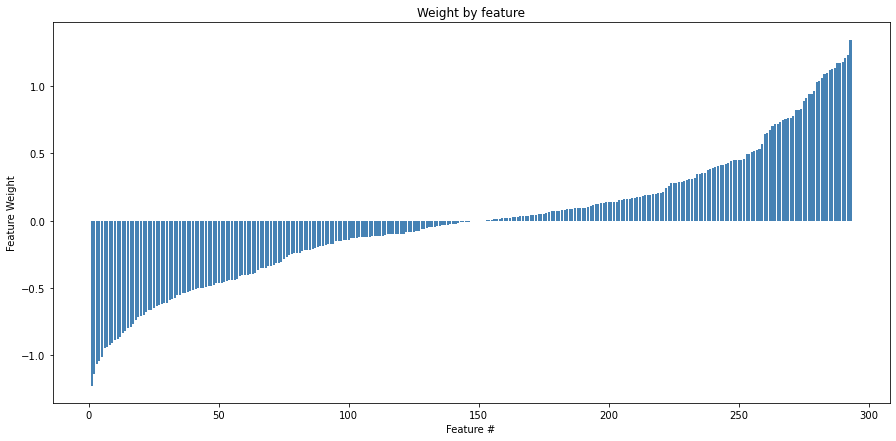

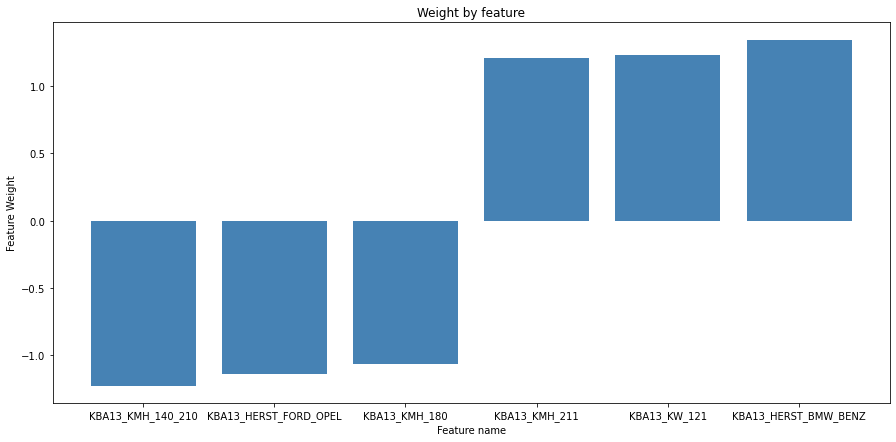

In [111]:
# get over-represented cluster 6 weights by feature
under_cluster_6 = get_feature_weights_cluster(azdias_pca, kmeans, cluster=6)

# plot weights by feature for over-represented cluster 6 
plot_feature_weights_2(under_cluster_6)

**Over-represented Cluster 6**

Features `KBA13_HERST_BMW_BENZ`, `KBA13_KW_121` and `KAB13_KMH_211` show positive correlation whereas `KBA13_KMH_140_210`, `KBA13_HERST_FORD_OPEL`and `KBA13_KMH_180` show negative correlation.

According to the features information, `KBA13_HERST_BMW_BENZ` represents share of BMW & Mercedes, `KBA13_KW_121` represents share of cars with an engine power of more than 121KW and `KAB13_KMH_211` represents share of cars with a greater max speed than 210 km/h.

In contrast, `KBA13_KMH_140_210`, `KBA13_HERST_FORD_OPEL`and `KBA13_KMH_180` represent less powerful and less luxurious cars.

This cluster corresponds to people that own **luxurious and very powerful cars.**

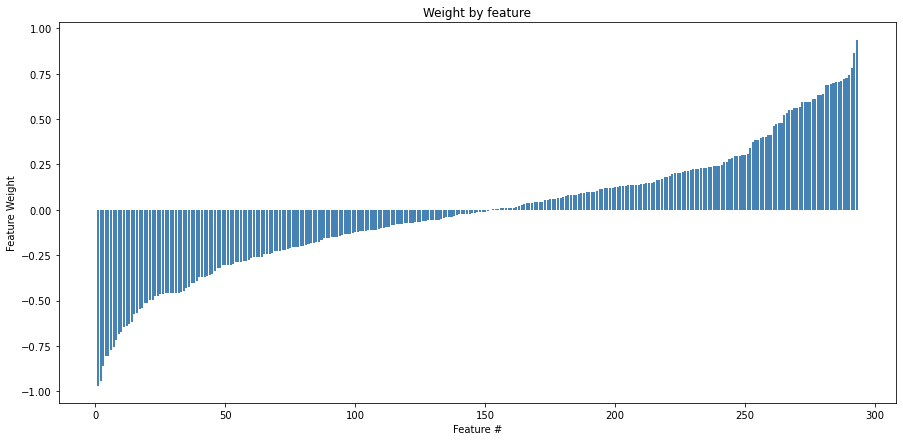

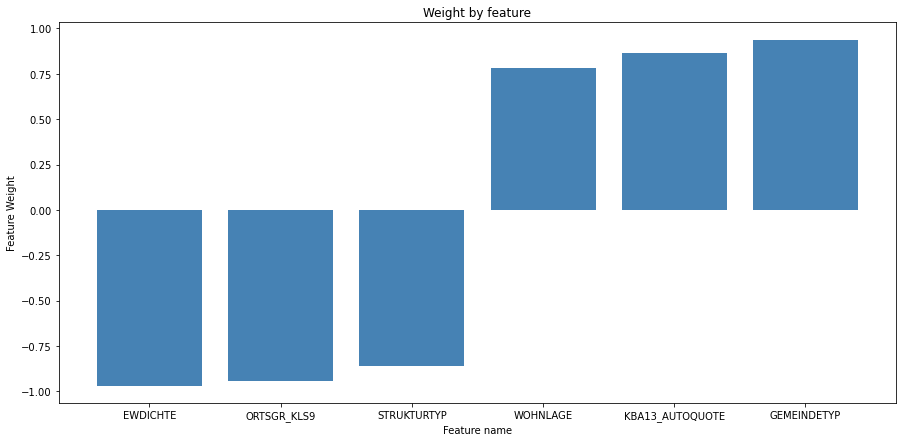

In [112]:
# get over-represented cluster 7 weights by feature
under_cluster_7 = get_feature_weights_cluster(azdias_pca, kmeans, cluster=7)

# plot weights by feature for over-represented cluster 7 
plot_feature_weights_2(under_cluster_7)

**Over-represented Cluster 7**

Features `GEMEINDETYP`, `KBA13_AUTOQUOTE` and `WOHNLAGE` show positive correlation whereas `EWDICHTE`, `ORTSGR_KLS9` and `STRUKTURTYP` show negative correlation.

According to the features information, `KBA13_AUTOQUOTE` represents share of cars in the household and `WOHNLAGE` represents good neighborhood areas. I do not have a feature meaning for `GEMEINDETYP` but *Gemeinde* means municipality so it probably captures information about areas.

In contrast, `EWDICHTE` represents the density of inhabitants per square kilometer, `ORTSGR_KLS9` represents classified number of inhabitants. I do not have a feature meaning for `STRUKTURTYP` but *Struktur* means structure so it probably captures information about the amount of structures per inhabitant.

It is hard to clearly define this cluster. I would suggest these are **people who live in good neighborhood areas and municipalities and that own more than one car in the household.**

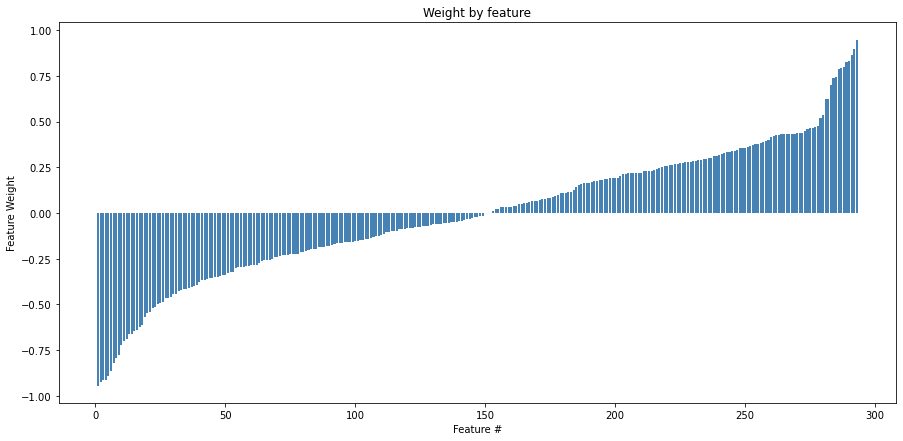

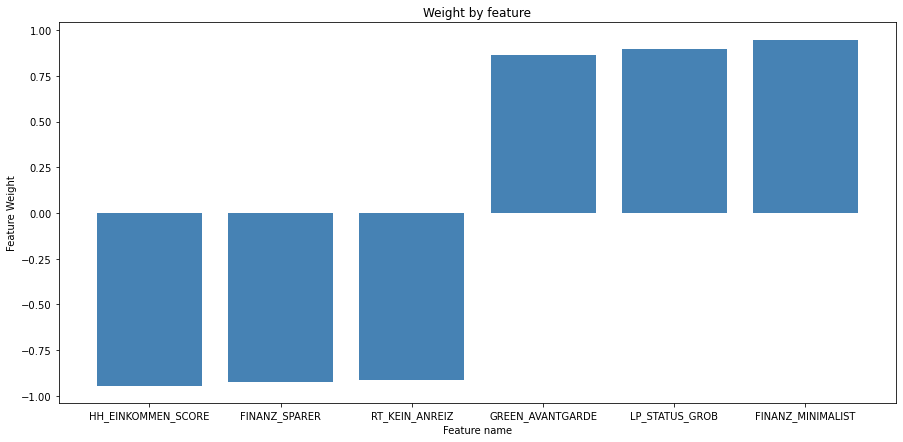

In [113]:
# get over-represented cluster 9 weights by feature
under_cluster_9 = get_feature_weights_cluster(azdias_pca, kmeans, cluster=9)

# plot weights by feature for over-represented cluster 9 
plot_feature_weights_2(under_cluster_9)

**Over-represented Cluster 9**

Features `FINANZ_MINIMALIST`, `LP_STATUS_GROB` and `GREEN_AVANTGARDE` show positive correlation whereas `HH_EINKOMMEN_SOCRE`, `FINANZ_SPARER`and `RT_KEIN_ANREIZ` show negative correlation.

According to the features information, `FINANZ_MINIMALIST` represents people who normally look for low financial interests, `LP_STATUS_GROB` represents social status rough and `GREEN_AVANTGARDE` represents people whose movement in the youth is/was the environmental sustainability.

In contrast, `HH_EINKOMMEN_SOCRE` represents the estimated household income, `FINANZ_SPARER` represents money savers and I do not have a feature meaning for `RT_KEIN_ANREIZ` but *Kein anreiz* means without enticement.

This cluster likey corresponds to **young people slightly dissapointed with their social status who look for low interest financial services.**

## 3. Conclusions

Due to the lack of meaning for some of the features utilised in the analysis, it is hard to describe some of the clusters. I would probably drop features without feature meaning if I had to carry out the cluster analysis again or I would come back to people with business domain knowledge if possible.

However, I have been able to identify the following **groups of potential customers:**

- Individuals that own luxurious and powerful cars and, therefore, these are likely to be in a good financial position and have high incomes.

- Individuals that live in good neighborhood areas and municipalitie. Also there is more than one car in their household.

- Relatively young individuals with great interest in environmental sustainability, that are somewhat dissapointed with their current social status and interested in low interest rates financial services.

If the company were to launch a marketing campaign for the current services, it would be sensible to target these groups of people.

I have also identified some **groups of the German population that are under-represented in the customers base:**

- Young people with average cars and income.

- Money savers with low interest in financial services.

- Young people with low-midclass cars and low income.

If the company were looking to reach a larger part of the German population, it might be worth designing some type of financial service that aligns with the needs of these groups and target them with a different marketing campaign. The company would need to consider the profitability of these services though before launching them as it is probably that customers of these profile will not tend to spend a lot of money often.